# Assess the Output of a Saved Model

This notebook allows you to load the weights of a trained U-Net model, pass data to it, and turn the model's output back in to audio, for subjective assesment against the original mixed and isolated signals.

In [1]:
#  Import a bunch of stuff
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir)

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['image.cmap'] = 'hot'
import IPython.display as ipd
import tensorflow as tf

import audio_functions as af
import audio_models
import dataset

/usr/local/lib/python3.5/dist-packages/pandas/core/computation/__init__.py:18: UserWarning: The installed version of numexpr 2.4.3 is not supported in pandas and will be not be used
The minimum supported version is 2.4.6

  ver=ver, min_ver=_MIN_NUMEXPR_VERSION), UserWarning)
Using TensorFlow backend.


### Get the variables and data ready

In [13]:
#  Set variables
sample_rate=16384
n_fft=1024
fft_hop=256
patch_window=256
patch_hop=128
n_parallel_readers=4
normalise=True
batch_size = 5
shuffle=False
n_shuffle = 1

checkpoint = '52/52-11'
model_base_dir = '/home/enterprise.internal.city.ac.uk/acvn728/checkpoints'

#directory_a = 'C:/Users/Toby/MSc_Project/Test_Audio/CHiME/test/Mixed'
#directory_b = 'C:/Users/Toby/MSc_Project/Test_Audio/CHiME/test/Voice'

#directory_a = 'C:/Users/Toby/Speech_Data/LibriSpeechMini/Mixed/train-clean-100/19/198/'
#directory_b = 'C:/Users/Toby/Speech_Data/LibriSpeechMini/Voice/train-clean-100/19/198/'

directory_a = '/home/enterprise.internal.city.ac.uk/acvn728/LibriSpeechMini/Mixed/train-clean-100/19/198/'
directory_b = '/home/enterprise.internal.city.ac.uk/acvn728/LibriSpeechMini/Voice/train-clean-100/19/198/'

#  Create the pipeline
tf.reset_default_graph()
data = dataset.zip_files(directory_a, directory_b)
data = dataset.get_paired_dataset(data,
                                  sample_rate,
                                  n_fft,
                                  fft_hop,
                                  patch_window,
                                  patch_hop,
                                  n_parallel_readers,
                                  batch_size,
                                  n_shuffle,
                                  normalise)

#  Create the iterator
mixed_spec, voice_spec, mixed_audio, voice_audio = data.make_one_shot_iterator().get_next()

#  Create variable placeholders
is_training = tf.placeholder(shape=(), dtype=bool)
mixed_mag = tf.expand_dims(mixed_spec[:, :, :-1, 0], 3)
mixed_phase = tf.expand_dims(mixed_spec[:, :, :-1, 1], 3)
voice_mag = tf.expand_dims(voice_spec[:, :, :-1, 0], 3)

In [14]:
data

<PrefetchDataset shapes: ((?, 256, 513, 2), (?, 256, 513, 2), (?, 65280, 1), (?, 65280, 1)), types: (tf.float32, tf.float32, tf.float32, tf.float32)>

### Define the model structure

In [15]:
# Build U-Net model
print('Creating model')
model = audio_models.AudioModel(mixed_mag, voice_mag, mixed_phase, mixed_audio, voice_audio, 'unet', is_training, name='U_Net_Model')
sess = tf.Session()
sess.run(tf.global_variables_initializer())

Creating model


### Load the saved weights - Skip this cell to hear results from a randomly initialised network

In [16]:

print('Loading checkpoint')
checkpoint_path = os.path.join(model_base_dir, checkpoint)
restorer = tf.train.Saver()
restorer.restore(sess, checkpoint_path)

Loading checkpoint
INFO:tensorflow:Restoring parameters from /home/enterprise.internal.city.ac.uk/acvn728/checkpoints/52/52-11


### Run a batch

In [28]:
mix_mag, mix_phase, voice_mag, voice_est_mag, mask, voice_wave, mix_wave = sess.run([model.mixed_mag, 
                                                                                     model.mixed_phase, 
                                                                                     model.voice_mag,
                                                                                     model.gen_voice, 
                                                                                     model.voice_mask, 
                                                                                     model.voice_audio, 
                                                                                     model.mixed_audio],
                                                                                    {model.is_training:False})
voice_est_wave = list()

for i in range(voice_mag.shape[0]):
    voice_est_wave.append(af.spectrogramToAudioFile(np.squeeze(voice_est_mag[i, :, :, :]).T, n_fft,
                                                    fft_hop, phaseIterations=0, phase=np.squeeze(mix_phase[i, :, :, :]).T))


### Listen to the output

The output will consist of up to [batch_size] clips from a single recording.

In [29]:
len(voice_est_wave)

5

In [50]:
#  The original mixture
ipd.Audio(mix_wave[3].T, rate=sample_rate)

In [34]:
#  The original isolated voice
ipd.Audio(voice_wave[1].T, rate=sample_rate)

In [35]:
#  The estimated isolated voice produced by the network
ipd.Audio(voice_est_wave[1], rate=sample_rate)

In [20]:
len(voice_est_wave[0])

65280

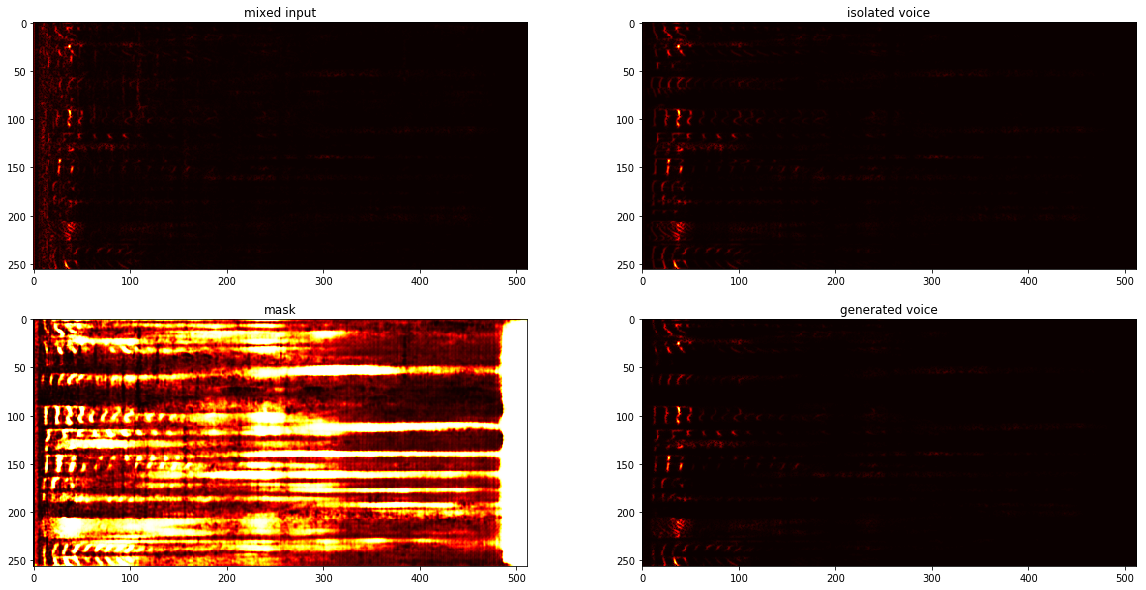

In [36]:
fig, ax = plt.subplots(2,2, figsize=(20,10))

ax[0,0].imshow(mix_mag[0,:,:,0])
ax[0,0].set_title('mixed input')
ax[0,1].imshow(voice_mag[0,:,:,0])
ax[0,1].set_title('isolated voice')
ax[1,0].imshow(mask[0,:,:,0])
ax[1,0].set_title('mask')
ax[1,1].imshow(voice_est_mag[0,:,:,0])
ax[1,1].set_title('generated voice')
plt.show()

# Reconstruction Investigation

In [39]:
import matplotlib.pyplot as plt
import mir_eval
#import museval

In [19]:
x = range(1000)

In [40]:
x = range(voice_wave[1].shape[0])
metrics = {}
metrics['mix'] = mir_eval.separation.bss_eval_sources(voice_wave[1].T, mix_wave[1].T, compute_permutation=False)
metrics['voice'] = mir_eval.separation.bss_eval_sources(voice_wave[1].T, voice_wave[1].T, compute_permutation=False)
metrics['voice_est'] = mir_eval.separation.bss_eval_sources(voice_wave[1].T, voice_est_wave[1].T, compute_permutation=False)
#metrics['sim_noise'] = mir_eval.separation.bss_eval_sources(voice_wave[1].T, noisy_wave.T, compute_permutation=False)

/home/enterprise.internal.city.ac.uk/acvn728/.local/lib/python3.5/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


(array([1.70872448]), array([inf]), array([1.70872448]), array([0]))


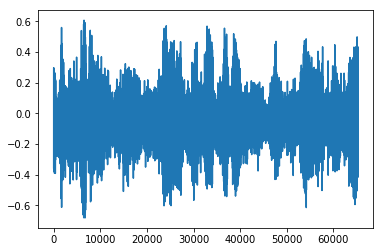

In [41]:
#  The original mixture
print(metrics['mix'])
plt.plot(x,mix_wave[0])
ipd.Audio(mix_wave[0].T, rate=sample_rate)

(array([266.680879]), array([inf]), array([266.680879]), array([0]))


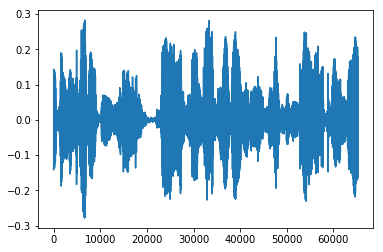

In [42]:
#  The original isolated voice
print(metrics['voice'])
plt.plot(x,voice_wave[0])
ipd.Audio(voice_wave[0].T, rate=sample_rate)

(array([10.64858647]), array([inf]), array([10.64858647]), array([0]))


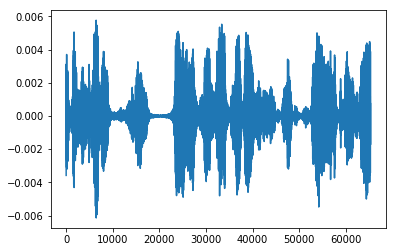

In [43]:
#  The estimated isolated voice produced by the network
print(metrics['voice_est'])
plt.plot(x,voice_est_wave[0])
ipd.Audio(voice_est_wave[0], rate=sample_rate)

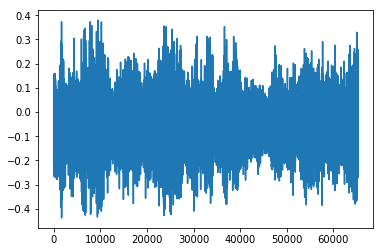

In [44]:
#  The background noise
#print(metrics['mix'])
plt.plot(x,(mix_wave[0]-voice_wave[0]))
ipd.Audio((mix_wave[0]-voice_wave[0]).T, rate=sample_rate)

In [45]:
bg_ref_mag = mix_mag - voice_mag
bg_est_mag = mix_mag - voice_est_mag
bg_ref_wave = []
bg_est_wave = []
for i in range(bg_ref_mag.shape[0]):
    bg_ref_wave.append(af.spectrogramToAudioFile(np.squeeze(bg_ref_mag[i, :, :, :]).T, n_fft,
                                                    fft_hop, phaseIterations=0, phase=np.squeeze(mix_phase[i, :, :, :]).T))
    
for i in range(bg_est_mag.shape[0]):
    bg_est_wave.append(af.spectrogramToAudioFile(np.squeeze(bg_est_mag[i, :, :, :]).T, n_fft,
                                                    fft_hop, phaseIterations=0, phase=np.squeeze(mix_phase[i, :, :, :]).T))

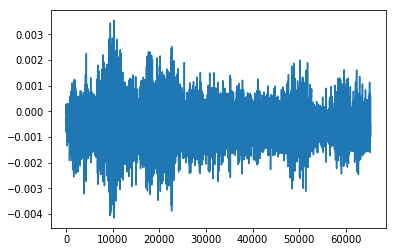

In [46]:
#  The background noise
#print(metrics['mix'])
x = range(bg_est_wave[0].shape[0])
plt.plot(x,bg_est_wave[0])
ipd.Audio(bg_est_wave[0].T, rate=sample_rate)

In [53]:
ipd.Audio(bg_est_wave[0].T, rate=sample_rate)

In [9]:
ref_sources = np.concatenate((voice_wave[0], np.expand_dims(bg_ref_wave[0], axis=1)), axis=1)
est_sources = np.concatenate((np.expand_dims(voice_est_wave[0], axis=1), np.expand_dims(bg_est_wave[0], axis=1)), axis=1)

In [11]:
sdr, sir, sar, _ = mir_eval.separation.bss_eval_sources(ref_sources.T, est_sources.T, compute_permutation=False)

C:\Program Files\Anaconda3\lib\site-packages\scipy\fftpack\basic.py:159: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


In [14]:
print(sdr)
print(sar)
print(sdr-sar)

[17.01488705 10.2295111 ]
[17.61829051 11.31720198]
[-0.60340345 -1.08769088]


In [21]:
test_array = np.empty((0,2))
test_array = np.concatenate((np.expand_dims(sdr, 1),np.expand_dims(sar, 1)), axis=1)
test_array

array([[17.01488705, 17.61829051],
       [10.2295111 , 11.31720198]])

In [25]:
np.mean(test_array, axis=0)

array([13.62219908, 14.46774625])

In [26]:
test_array.shape

(2, 2)

In [27]:
sdrs = [[],[],[],[],[]]
for j in range(len(voice_wave)):
    for i in range(1,1000):
        sdrs[j].append(mir_eval.separation.bss_eval_sources(voice_wave[j][i:].T, voice_est_wave[j][:-i].T, compute_permutation=False)[0][0])

C:\Program Files\Anaconda3\lib\site-packages\scipy\fftpack\basic.py:159: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


In [28]:
len(sdrs[0])

999

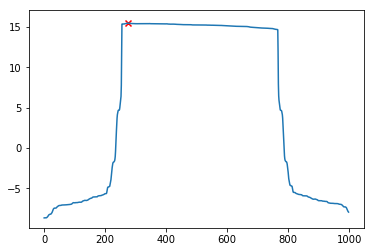

In [340]:
x = range(len(sdrs))
max_idx = sdrs.index(max(sdrs))
plt.plot(x,sdrs)
plt.scatter(max_idx,sdrs[max_idx], c='r', marker = 'x')

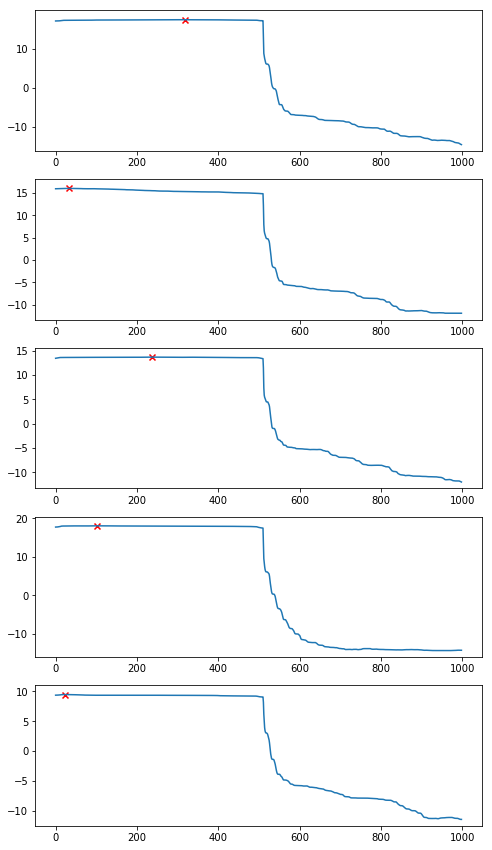

In [29]:
fig, ax = plt.subplots(5,1, figsize=(8,15))
for i in range(len(sdrs)):
    x = range(len(sdrs[i]))
    max_idx = sdrs[i].index(max(sdrs[i]))
    ax[i].plot(x,sdrs[i])
    ax[i].scatter(max_idx,sdrs[i][max_idx], c='r', marker = 'x')

In [6]:
from functools import partial
import librosa
import importlib
importlib.reload(af)

<module 'audio_functions' from 'C:\\Users\\Toby\\MSc_Project\\MScFinalProject\\audio_functions.py'>

In [50]:
def get_paired_dataset(zipped_files,
                       sample_rate,
                       n_fft,
                       fft_hop,
                       patch_window,
                       patch_hop,
                       n_parallel_readers,
                       batch_size,
                       n_shuffle,
                       normalise):

    return (
        tf.data.Dataset.from_tensor_slices((zipped_files[:, 0], zipped_files[:, 1]))
        .map(partial(af.read_audio_pair,
                     sample_rate=sample_rate),
             num_parallel_calls=n_parallel_readers)
        .map(partial(af.extract_audio_patches_map,
                     fft_hop=fft_hop,
                     patch_window=patch_window,
                     patch_hop=patch_hop,),
             num_parallel_calls=n_parallel_readers)
        .flat_map(Utils.zip_tensor_slices)
        .map(partial(af.compute_spectrogram_map,
                     n_fft=n_fft,
                     fft_hop=fft_hop,
                     normalise=normalise),
             num_parallel_calls=n_parallel_readers)
        .shuffle(n_shuffle).batch(batch_size).prefetch(3)
    )

In [15]:
def get_paired_dataset(zipped_files,
                       sample_rate,
                       n_fft,
                       fft_hop,
                       patch_window,
                       patch_hop,
                       n_parallel_readers,
                       batch_size,
                       n_shuffle,
                       normalise):

    return (
        tf.data.Dataset.from_tensor_slices((zipped_files[:, 0], zipped_files[:, 1]))
        .map(partial(af.read_audio_pair,
                     sample_rate=sample_rate),
             num_parallel_calls=n_parallel_readers)
        .map(partial(af.compute_spectrogram_map,
                     n_fft=n_fft,
                     fft_hop=fft_hop,
                     normalise=normalise),
             num_parallel_calls=n_parallel_readers)
#        .map(partial(af.extract_patches_map,
#                     n_fft=n_fft,
#                     fft_hop=fft_hop,
#                     patch_window=patch_window,
#                     patch_hop=patch_hop,),
#             num_parallel_calls=n_parallel_readers)
#        .flat_map(Utils.zip_tensor_slices)
#        .shuffle(n_shuffle).batch(batch_size).prefetch(3)
    )

In [7]:
#  Set variables
sample_rate=16384
n_fft=1024
fft_hop=256
patch_window=256
patch_hop=128
n_parallel_readers=4
normalise=True
batch_size = 2
shuffle=False
n_shuffle = 1

checkpoint = '43/43-1001'
model_base_dir = 'C:/Users/Toby/MSc_Project/MScFinalProjectCheckpoints'

#directory_a = 'C:/Users/Toby/MSc_Project/Test_Audio/CHiME/test/Mixed'
#directory_b = 'C:/Users/Toby/MSc_Project/Test_Audio/CHiME/test/Voice'

directory_a = 'C:/Users/Toby/Speech_Data/LibriSpeechMini/Mixed/train-clean-100/19/198/'
directory_b = 'C:/Users/Toby/Speech_Data/LibriSpeechMini/Voice/train-clean-100/19/198/'

#directory_a = '/home/enterprise.internal.city.ac.uk/acvn728/LibriSpeechMini/Mixed/train-clean-100/19/198/'
#directory_b = '/home/enterprise.internal.city.ac.uk/acvn728/LibriSpeechMini/Voice/train-clean-100/19/198/'

#  Create the pipeline
tf.reset_default_graph()
data = dataset.zip_files(directory_a, directory_b)
data = dataset.get_paired_dataset(data,
                                  sample_rate,
                                  n_fft,
                                  fft_hop,
                                  patch_window,
                                  patch_hop,
                                  n_parallel_readers,
                                  batch_size,
                                  n_shuffle,
                                  normalise)

In [8]:
data

<PrefetchDataset shapes: ((?, 256, 513, 2), (?, 256, 513, 2), (?, 65280, 1), (?, 65280, 1)), types: (tf.float32, tf.float32, tf.float32, tf.float32)>